In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yellowbrick as yb
import shap
import lime

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
folder_path = "E:\\Formation Data Scientist\\Projet_5\\ressources\\archive\\"
customers = pd.read_csv(folder_path + "olist_customers_dataset.csv")
order_items = pd.read_csv(folder_path + "olist_order_items_dataset.csv")
orders = pd.read_csv(folder_path + "olist_orders_dataset.csv")
geolocation = pd.read_csv(folder_path + 'olist_geolocation_dataset.csv')
order_payments = pd.read_csv(folder_path + 'olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(folder_path + 'olist_order_reviews_dataset.csv')
products = pd.read_csv(folder_path + 'olist_products_dataset.csv')
sellers = pd.read_csv(folder_path + 'olist_sellers_dataset.csv')
translation = pd.read_csv(folder_path + 'product_category_name_translation.csv')


In [4]:
print(customers.shape)
print(order_items.shape)
print(orders.shape)
print(geolocation.shape)
print(order_payments.shape)
print(order_reviews.shape)
print(products.shape)
print(sellers.shape)
print(translation.shape)

(99441, 5)
(112650, 7)
(99441, 8)
(1000163, 5)
(103886, 5)
(99224, 7)
(32951, 9)
(3095, 4)
(71, 2)


In [5]:
customers.head(1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP


In [6]:
orders.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00


In [7]:
geolocation.head(1)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP


- Merge des catégories de produits et leur nom en Anglais

In [8]:
fus_cats = pd.merge(products,translation,indicator=True)

In [9]:
fus_cats.head(1)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,_merge
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,both


- Drop des colonnes non essentielles

In [10]:
fus_cats.drop(columns=['product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g','product_length_cm','product_height_cm',
              'product_width_cm','_merge'],inplace=True)

In [11]:
fus_cats.shape

(32328, 3)

In [12]:
fus_cats.isna().sum()

product_id                       0
product_category_name            0
product_category_name_english    0
dtype: int64

- Fusion de la trame des **clients** et de la trame des **commandes**

In [13]:
fus1 = pd.merge(customers,orders, indicator=True)

In [14]:
fus1.shape

(99441, 13)

In [15]:
fus1.head(1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,_merge
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,both


In [16]:
fus1 = fus1.drop(columns='_merge')

- Fusion de la trame des **clients** et **commandes** avec la trame **paiements**

In [17]:
fus2 = pd.merge(fus1,order_payments, indicator=True)

In [18]:
fus2

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,_merge
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,credit_card,2,146.87,both
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1,credit_card,8,335.48,both
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1,credit_card,7,157.73,both
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1,credit_card,1,173.30,both
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1,credit_card,8,252.25,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103881,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25 00:00:00,1,credit_card,6,88.78,both
103882,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20 00:00:00,1,credit_card,3,129.06,both
103883,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02 00:00:00,1,credit_card,5,56.04,both
103884,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05 00:00:00,1,credit_card,2,711.07,both


In [19]:
fus2 = fus2.drop(columns='_merge')

- Fusion de la trame des **produits** avec celle des **catégories** de produits

In [20]:
fus3 = pd.merge(order_items,fus_cats)

In [21]:
fus4 = pd.merge(fus3,fus2)

In [22]:
fus4.isna().sum()

order_id                            0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
product_category_name               0
product_category_name_english       0
customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  14
order_delivered_carrier_date     1205
order_delivered_customer_date    2495
order_estimated_delivery_date       0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
dtype: int64

In [23]:
#fus4.dropna(axis=0,inplace=True)

In [24]:
fus4.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_english,customer_id,...,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,cool_stuff,3ce436f183e68e07877b285a838db11a,...,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,1,credit_card,2,72.19


In [25]:
fus4.shape

(115878, 24)

In [26]:
fus4.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_category_name_english', 'customer_id',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value'],
      dtype='object')

In [27]:
fus5 = pd.merge(fus4,sellers)

In [28]:
fus5.shape

(115878, 27)

In [29]:
fus5.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_category_name_english', 'customer_id',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'seller_zip_code_prefix', 'seller_city',
       'seller_state'],
      dtype='object')

In [30]:
#fus5 = pd.merge(fus4,geolocation,left_on='customer_zip_code_prefix',right_on='geolocation_zip_code_prefix',indicator=True)

In [31]:
fus5.shape

(115878, 27)

<AxesSubplot:>

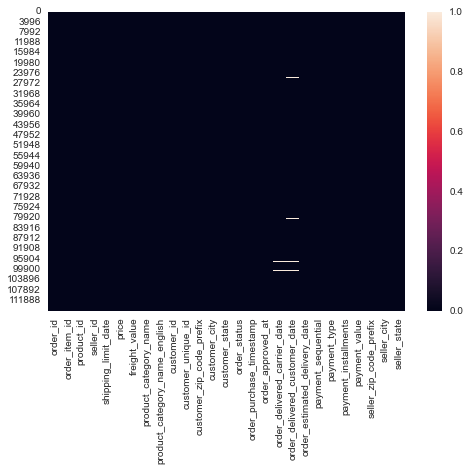

In [32]:
sns.heatmap(fus5.isna())

In [33]:
fus5.isna().sum()

order_id                            0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
product_category_name               0
product_category_name_english       0
customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  14
order_delivered_carrier_date     1205
order_delivered_customer_date    2495
order_estimated_delivery_date       0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
seller_zip_code_prefix              0
seller_city                         0
seller_state

In [34]:
fus5.duplicated().sum()

0

In [35]:
fus5['customer_unique_id'].value_counts()

9a736b248f67d166d2fbb006bcb877c3    75
6fbc7cdadbb522125f4b27ae9dee4060    38
f9ae226291893fda10af7965268fb7f6    35
8af7ac63b2efbcbd88e5b11505e8098a    29
569aa12b73b5f7edeaa6f2a01603e381    26
                                    ..
3550a2cc16b097ea0b1a13d45fb93272     1
de0fcbf13e92c68080d909e87da3b510     1
2432c58848b4d5e5129a2708db9ee06f     1
deff2c7ac22cbeadd688e67271ba57ba     1
e243299898defc77002df4a5e3c31b4d     1
Name: customer_unique_id, Length: 94087, dtype: int64

In [36]:
fus5['payment_value'].describe()

count    115878.000000
mean        173.016646
std         268.110998
min           0.000000
25%          61.010000
50%         108.200000
75%         189.720000
max       13664.080000
Name: payment_value, dtype: float64

<a name='C2'> **EDA** </a>

- **Formatage** des dates en DateTime

In [37]:
date = ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']
for i in date:
  fus5[i] = pd.to_datetime(fus5[i],format="%Y-%m-%d %H:%M:%S")
  
fus5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115878 entries, 0 to 115877
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115878 non-null  object        
 1   order_item_id                  115878 non-null  int64         
 2   product_id                     115878 non-null  object        
 3   seller_id                      115878 non-null  object        
 4   shipping_limit_date            115878 non-null  object        
 5   price                          115878 non-null  float64       
 6   freight_value                  115878 non-null  float64       
 7   product_category_name          115878 non-null  object        
 8   product_category_name_english  115878 non-null  object        
 9   customer_id                    115878 non-null  object        
 10  customer_unique_id             115878 non-null  object        
 11  

In [38]:
fus6 = fus5.copy()
fus6['year'] = fus6['order_purchase_timestamp'].dt.year
fus6['month'] = fus6['order_purchase_timestamp'].dt.month
fus6['day'] = fus6['order_purchase_timestamp'].dt.dayofweek
fus6['day_name'] = fus6['order_purchase_timestamp'].dt.day_name()
fus6['month_name'] = fus6['order_purchase_timestamp'].dt.month_name()

In [39]:
fus6.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_english,customer_id,...,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state,year,month,day,day_name,month_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,cool_stuff,3ce436f183e68e07877b285a838db11a,...,2,72.19,27277,volta redonda,SP,2017,9,2,Wednesday,September


In [40]:
fus6['month_name'].unique()

array(['September', 'June', 'May', 'August', 'July', 'March', 'October',
       'April', 'November', 'February', 'December', 'January'],
      dtype=object)

- **Drop** des Null

In [41]:
drop1 = fus6.copy()
drop1 = drop1.dropna(axis=0)
drop1.shape

(113368, 32)

In [42]:
drop1.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_category_name_english', 'customer_id',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'year', 'month', 'day', 'day_name', 'month_name'],
      dtype='object')

Nous avons besoin des colonnes qui nous donnent des informations sur la **récense**, la **fréquence** et le **montant** des transactions

Drop des features non essentiels

In [43]:
#drop2 = drop1.drop(columns=['customer_city', 'order_status','order_delivered_carrier_date','order_delivered_customer_date', 'order_estimated_delivery_date','seller_city','seller_state','shipping_limit_date'])

In [44]:
drop1.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_english,customer_id,...,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state,year,month,day,day_name,month_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,cool_stuff,3ce436f183e68e07877b285a838db11a,...,2,72.19,27277,volta redonda,SP,2017,9,2,Wednesday,September


In [45]:
drop1.describe()

,order_item_id,price,freight_value,customer_zip_code_prefix,payment_sequential,payment_installments,payment_value,seller_zip_code_prefix,year,month,day
count,113368.000000,113368.000000,113368.000000,113368.000000,113368.000000,113368.000000,113368.000000,113368.000000,113368.000000,113368.000000,113368.000000
mean,1.196854,120.177066,20.024293,35082.345071,1.089946,2.942594,172.237791,24514.457307,2017.542534,6.038468,2.744787
std,0.701322,182.793493,15.753267,29845.780275,0.682117,2.777913,266.627878,27638.693371,0.504086,3.221644,1.961454
min,1.000000,0.850000,0.000000,1003.000000,1.000000,0.000000,0.000000,1001.000000,2016.000000,1.000000,0.000000
25%,1.000000,39.900000,13.080000,11320.000000,1.000000,1.000000,61.000000,6429.000000,2017.000000,3.000000,1.000000
50%,1.000000,74.900000,16.320000,24325.000000,1.000000,2.000000,108.140000,13660.000000,2018.000000,6.000000,3.000000
75%,1.000000,133.717500,21.200000,58780.000000,1.000000,4.000000,189.370000,28495.000000,2018.000000,8.000000,4.000000
max,21.000000,6735.000000,409.680000,99980.000000,26.000000,24.000000,13664.080000,99730.000000,2018.000000,12.000000,6.000000


In [46]:
drop1.dtypes

order_id                                 object
order_item_id                             int64
product_id                               object
seller_id                                object
shipping_limit_date                      object
price                                   float64
freight_value                           float64
product_category_name                    object
product_category_name_english            object
customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
payment_sequential                      

<AxesSubplot:>

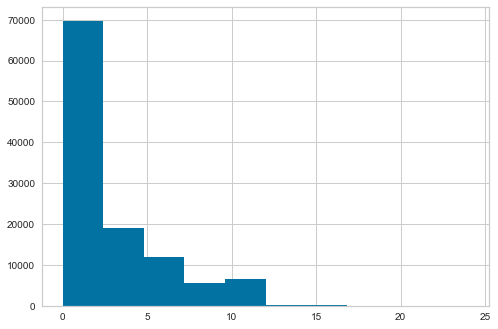

In [47]:
drop1['payment_installments'].hist(bins=10)

- Etude des clients par zone géographique

In [48]:
# Trouvons les états avec le plus de clients

customers_state = drop1.groupby(['customer_state']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id',ascending=False)
customers_state.rename(columns = {'customer_unique_id':'total'}, inplace=True)
customers_state['percentage'] = 100*(customers_state['total']/customers_state['total'].sum())
customers_state

,customer_state,total,percentage
25,SP,47819,42.180333
18,RJ,14648,12.920754
10,MG,13230,11.669960
22,RS,6283,5.542128
17,PR,5790,5.107261
23,SC,4161,3.670348
4,BA,3858,3.403077
6,DF,2389,2.107297
8,GO,2319,2.045551
7,ES,2288,2.018206


Sao Paulo est de loin l'état avec le plus de clients

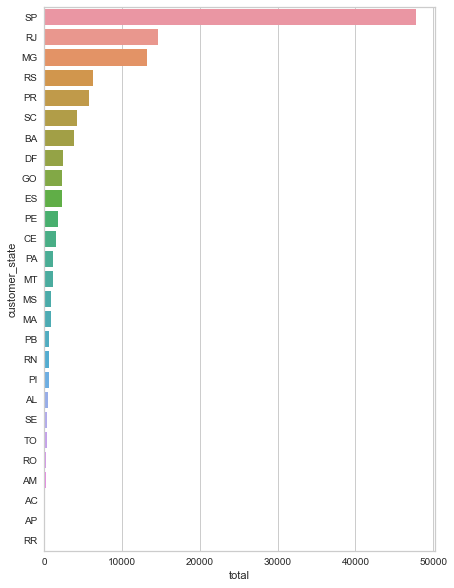

In [49]:
plt.figure(figsize=(7,10))
sns.barplot(data=customers_state,x='total',y='customer_state')
plt.show()

- Etude des clients par catégories de produits acheté

- Etude achats par date

In [50]:
purchase_year = drop1.groupby(['year']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id',ascending=False)
purchase_year.rename(columns = {'customer_unique_id':'total'}, inplace=True)
purchase_year['percentage'] = 100*(purchase_year['total']/purchase_year['total'].sum())
purchase_year

,year,total,percentage
2,2018,61841,54.548903
1,2017,51192,45.155599
0,2016,335,0.295498


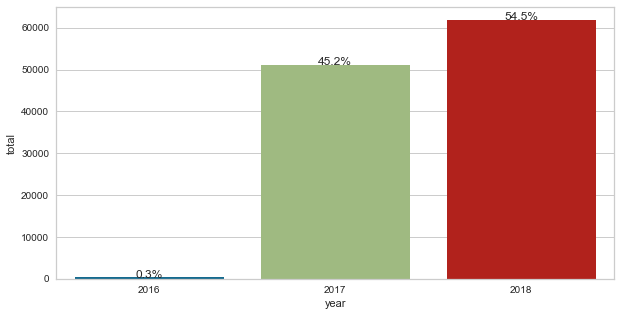

In [51]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=purchase_year,x='year',y='total')
total = purchase_year['total'].sum()
patches = ax.patches
for p in ax.patches:
   percentage = '{:.1f}%'.format(100 * p.get_height()/total)
   x = p.get_x() + p.get_width()/2
   y = p.get_height()+.05
   ax.annotate(percentage, (x, y), ha='center')
plt.show()

In [52]:
# the number of order per month
purchase_monthly = drop1[['order_approved_at']].groupby(drop1['order_approved_at'].dt.to_period('M')).agg({'order_approved_at':'count'})
purchase_monthly = purchase_monthly.rename(columns = {'order_approved_at': 'total'})
purchase_monthly = purchase_monthly.reset_index()

purchase_monthly['month_year'] = purchase_monthly['order_approved_at'].dt.strftime('%b-%Y')
purchase_monthly.head()

,order_approved_at,total,month_year
0,2016-10,334,Oct-2016
1,2016-12,1,Dec-2016
2,2017-01,906,Jan-2017
3,2017-02,1895,Feb-2017
4,2017-03,3028,Mar-2017


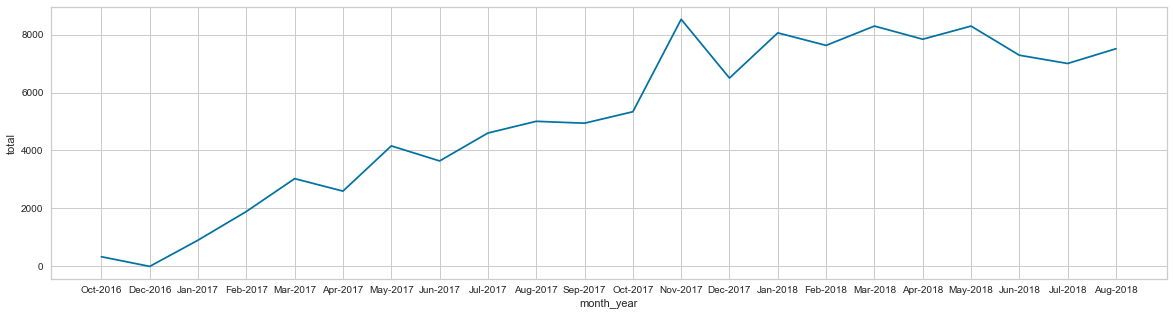

In [53]:
plt.figure(figsize=(20,5))
sns.lineplot(data=purchase_monthly,x='month_year',y='total')
plt.show()

Le plus grand nombre de commandes a été passé en Novembre 2017

In [54]:
order_monthly = drop1[['order_approved_at']].groupby(drop1['order_approved_at'].dt.month.sort_index()).count()
order_monthly

,order_approved_at
order_approved_at,
1,8963
2,9520
3,11320
4,10436
5,12449
6,10925
7,11603
8,12516
9,4941


In [55]:
month_index = order_monthly.rename(columns = {'order_approved_at': 'total_orders'})
monthly_trend = month_index.reset_index()

# rechange in to day in a week
moy = ['January','February','March','April','May','June','July','August','September','October','November','December']
for i in range(12):
  monthly_trend['order_approved_at'] = monthly_trend['order_approved_at'].replace(i,moy[i])
monthly_trend

,order_approved_at,total_orders
0,February,8963
1,March,9520
2,April,11320
3,May,10436
4,June,12449
5,July,10925
6,August,11603
7,September,12516
8,October,4941
9,November,5670


In [56]:
purchase_month = drop1.groupby(['month_name']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id',ascending=False)
purchase_month.rename(columns = {'customer_unique_id':'total'}, inplace=True)
purchase_month['percentage'] = 100*(purchase_month['total'] / purchase_month['total'].sum())
purchase_month

,month_name,total,percentage
1,August,12292,10.842566
8,May,12211,10.771117
5,July,11793,10.402406
7,March,11215,9.892562
6,June,10921,9.633230
0,April,10663,9.405652
3,February,9537,8.412427
4,January,9110,8.035777
9,November,8683,7.659128
2,December,6300,5.557124


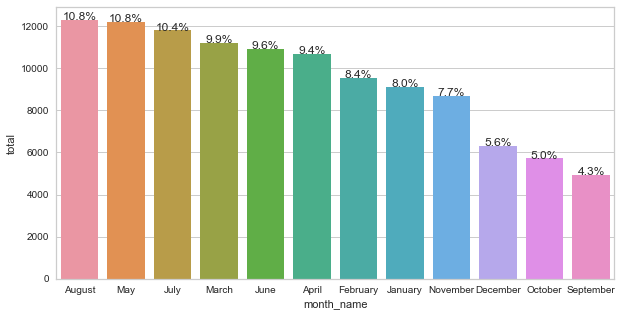

In [57]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=purchase_month,x='month_name',y='total')
total = purchase_month['total'].sum()
patches = ax.patches
for p in ax.patches:
   percentage = '{:.1f}%'.format(100 * p.get_height()/total)
   x = p.get_x() + p.get_width()/2
   y = p.get_height()+.05
   ax.annotate(percentage, (x, y), ha='center')
plt.show()

In [58]:
purchase_day = drop1.groupby(['day_name']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id',ascending=False)
purchase_day.rename(columns = {'customer_unique_id':'total'}, inplace=True)
purchase_day

,day_name,total
1,Monday,18452
5,Tuesday,18412
6,Wednesday,17730
4,Thursday,16916
0,Friday,16179
3,Sunday,13440
2,Saturday,12239


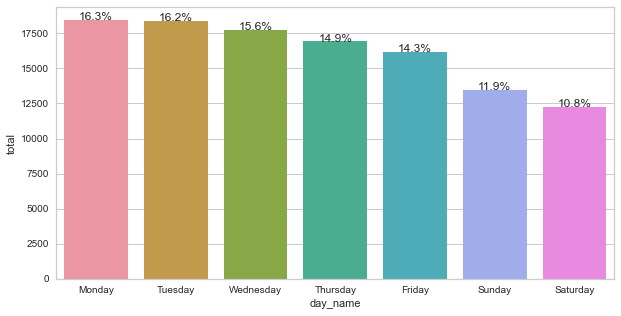

In [59]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=purchase_day,x='day_name',y='total')
total = purchase_day['total'].sum()
patches = ax.patches
for p in ax.patches:
   percentage = '{:.1f}%'.format(100 * p.get_height()/total)
   x = p.get_x() + p.get_width()/2
   y = p.get_height()+.05
   ax.annotate(percentage, (x, y), ha='center')
plt.show()

In [60]:
payment_type = drop1.groupby(['payment_type']).count()['customer_unique_id'].reset_index().sort_values(by='customer_unique_id',ascending=False)
payment_type.rename(columns = {'customer_unique_id':'total'}, inplace=True)
payment_type['percentage'] = 100*(payment_type['total'] / payment_type['total'].sum())
payment_type

,payment_type,total,percentage
1,credit_card,83696,73.826829
0,boleto,22040,19.441112
3,voucher,6011,5.302202
2,debit_card,1621,1.429857


Le moyen de paiement le plus populaire est la carte de crédit ensuite boleto

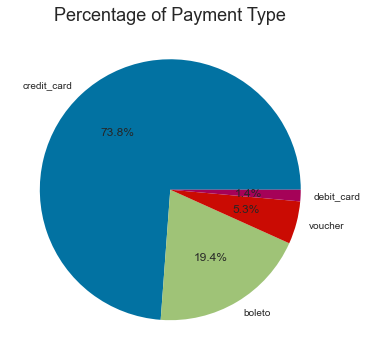

In [61]:
label = payment_type['payment_type']
plt.figure(figsize=(6,6))
plt.title('Percentage of Payment Type', fontsize = 18)
plt.pie(payment_type['total'], labels = label,autopct = '%0.1f%%')
plt.show()

<a name='C2'> - Classement par clients et commandes </a>

In [94]:
fus5.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_category_name_english', 'customer_id',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'seller_zip_code_prefix', 'seller_city',
       'seller_state'],
      dtype='object')

Calcul du nombre de clients ayant passé plus d'une commande

In [93]:
fus5.loc[fus5['customer_unique_id'] == 'ff4159b92c40ebe40454e3e6a7c35ed6'].reset_index()

,index,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_english,...,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state
0,115843,f5136e38d1a14a4dbd87dff67da82701,1,1bdf5e6731585cf01aa8169c7028d6ad,ee27a8f15b1dded4d213a468ba4eb391,2017-06-15 02:45:17,6499.0,227.66,artes,art,...,2017-05-26 11:20:47,2017-06-05 17:09:48,2017-06-28,1,boleto,1,6726.66,74210,goiania,GO


In [91]:
mean_payment = fus5[['customer_unique_id','payment_value']].groupby(by=['customer_unique_id'],dropna=False).mean().reset_index()
count_payment = fus5[['customer_unique_id','payment_value']].groupby(by=['customer_unique_id'],dropna=False).count().reset_index()
result = pd.merge(mean_payment, count_payment, how="inner", on='customer_unique_id',suffixes=('_avg', '_count'))
result.sort_values('payment_value_avg',ascending=False).reset_index(drop=True)

,customer_unique_id,payment_value_avg,payment_value_count
0,0a0a92112bd4c708ca5fde585afaa872,13664.080000,8
1,763c8b1c9c68a0229c42c9fc6f662b93,7274.880000,4
2,dc4802a71eae9be1dd28f5d788ceb526,6929.310000,1
3,459bef486812aa25204be022145caa62,6922.210000,1
4,ff4159b92c40ebe40454e3e6a7c35ed6,6726.660000,1
...,...,...,...
94082,c63a8c4fb13043a3fbe33bd17c69d17d,4.242500,8
94083,6bd5b501f37638859ccc1dc94cce730d,3.776667,9
94084,2bca5fe01d46ab5cc2bc5aaade88d850,3.166667,6
94085,569aa12b73b5f7edeaa6f2a01603e381,2.410769,26


In [84]:
customers_grp = fus5.groupby(['customer_unique_id','order_approved_at']).sum()
customers_grp

,,order_item_id,price,freight_value,customer_zip_code_prefix,payment_sequential,payment_installments,payment_value,seller_zip_code_prefix
customer_unique_id,order_approved_at,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18,1,129.90,12.00,7787,1,8,141.90,13405
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44,1,18.90,8.29,6053,1,1,27.19,2215
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,69.00,17.22,88115,1,8,86.22,13232
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17,1,25.99,17.63,66812,1,4,43.62,3569
0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52,1,180.00,16.89,18040,1,6,196.89,12327
...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:15:16,3,1570.00,497.42,110500,2,20,4134.84,7816
fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:16:20,1,64.89,19.69,44054,1,1,84.58,18500
ffff371b4d645b6ecea244b27531430a,2017-02-07 16:02:44,1,89.90,22.56,78552,1,1,112.46,30550


In [82]:
sorted_customers_grp = customers_grp['payment_value'].value_counts().sort_values(ascending=False)
sorted_customers_grp

customer_unique_id                order_approved_at    payment_value
9a736b248f67d166d2fbb006bcb877c3  2017-08-08 20:43:31  16.70            24
                                                       2.61             21
4546caea018ad8c692964e3382debd19  2017-07-17 18:25:23  196.11           21
c402f431464c72e27330a67f7b94d4fb  2018-02-24 03:20:27  2202.40          20
698e1cf81d01a3d389d96145f7fa6df8  2017-08-24 14:30:23  2262.80          20
                                                                        ..
598219425972fccc56733fc7919793a6  2017-10-05 10:07:21  216.05            1
5980fdd520297d363b32aa47c0232c5b  2018-05-03 04:52:37  47.23             1
5980f546cbb6a7df45ccae926feea7d0  2018-01-18 02:12:39  194.50            1
5980b203a36c933c512ab51a54f7f3c7  2018-06-04 02:10:00  113.11            1
ffffd2657e2aad2907e67c3e9daecbeb  2017-05-03 15:15:13  71.56             1
Name: payment_value, Length: 100970, dtype: int64

In [65]:
clients_num_orders = fus5.groupby('customer_unique_id').count()['order_approved_at'].sort_values(ascending=False)
clients_num_orders

customer_unique_id
9a736b248f67d166d2fbb006bcb877c3    75
6fbc7cdadbb522125f4b27ae9dee4060    38
f9ae226291893fda10af7965268fb7f6    35
8af7ac63b2efbcbd88e5b11505e8098a    29
569aa12b73b5f7edeaa6f2a01603e381    26
                                    ..
7e1a5ca61b572d76b64b6688b9f96473     0
c094ac95fcd52f821809ec232a7a6956     0
c4c0011e639bdbcf26059ddc38bd3c18     0
91efb7fcabc17925099dced52435837f     0
d49f3dae6bad25d05160fc17aca5942d     0
Name: order_approved_at, Length: 94087, dtype: int64

In [66]:
_clients_num_orders = fus5.groupby(['customer_unique_id','order_approved_at','payment_value'])['order_approved_at'].count().sort_values(ascending=False)
_clients_num_orders

customer_unique_id                order_approved_at    payment_value
9a736b248f67d166d2fbb006bcb877c3  2017-08-08 20:43:31  16.70            24
4546caea018ad8c692964e3382debd19  2017-07-17 18:25:23  196.11           21
9a736b248f67d166d2fbb006bcb877c3  2017-08-08 20:43:31  2.61             21
698e1cf81d01a3d389d96145f7fa6df8  2017-08-24 14:30:23  2262.80          20
c402f431464c72e27330a67f7b94d4fb  2018-02-24 03:20:27  2202.40          20
                                                                        ..
598219425972fccc56733fc7919793a6  2017-10-05 10:07:21  216.05            1
5980fdd520297d363b32aa47c0232c5b  2018-05-03 04:52:37  47.23             1
5980f546cbb6a7df45ccae926feea7d0  2018-01-18 02:12:39  194.50            1
5980b203a36c933c512ab51a54f7f3c7  2018-06-04 02:10:00  113.11            1
ffffd2657e2aad2907e67c3e9daecbeb  2017-05-03 15:15:13  71.56             1
Name: order_approved_at, Length: 100970, dtype: int64

In [67]:
sum(clients_num_orders.values > 1)


14098

In [68]:
df_ = fus5[['customer_unique_id','order_approved_at','payment_value']].copy()
df_.head()

,customer_unique_id,order_approved_at,payment_value
0,871766c5855e863f6eccc05f988b23cb,2017-09-13 09:45:35,72.19
1,0fb8e3eab2d3e79d92bb3fffbb97f188,2017-06-29 02:44:11,73.86
2,3419052c8c6b45daf79c1e426f9e9bcb,2018-05-18 12:31:43,83.23
3,e7c828d22c0682c1565252deefbe334d,2017-08-01 18:55:08,75.07
4,0bb98ba72dcc08e95f9d8cc434e9a2cc,2017-08-10 22:05:11,72.19


In [69]:
df_clients = df_.groupby('customer_unique_id')[['order_approved_at','payment_value']].mean()
df_clients

,payment_value
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
0000f46a3911fa3c0805444483337064,86.22
0000f6ccb0745a6a4b88665a16c9f078,43.62
0004aac84e0df4da2b147fca70cf8255,196.89
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2067.42
fffea47cd6d3cc0a88bd621562a9d061,84.58
ffff371b4d645b6ecea244b27531430a,112.46


Calcul de la date de la première commande et celle de la dernière commande

In [70]:
print(f'Min : {min(fus5.order_approved_at)}, Max : {max(fus5.order_approved_at)}')

Min : 2016-10-04 09:43:32, Max : 2018-09-03 17:40:06


Nous allons utiliser la date de la dernière commande + 1 comme date de reference , afin de calculer la récense des commandes

In [71]:
last_date = fus5['order_approved_at'].max() + pd.to_timedelta(1, 'd')
last_date

Timestamp('2018-09-04 17:40:06')

In [108]:
rfm = fus5.reset_index()\
          .groupby('customer_unique_id')\
          .agg(Recency = ('order_approved_at', lambda x: (last_date - x.max()).days ),
                 Frequency = ('order_id', 'size'),
                 Monetary = ('payment_value', 'sum'))

In [109]:
rfm

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,117.0,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,119.0,1,27.19
0000f46a3911fa3c0805444483337064,542.0,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,326.0,1,43.62
0004aac84e0df4da2b147fca70cf8255,293.0,1,196.89
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,452.0,2,4134.84
fffea47cd6d3cc0a88bd621562a9d061,267.0,1,84.58
ffff371b4d645b6ecea244b27531430a,574.0,1,112.46


In [110]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,94075.0,242.946862,153.125240,1.00,119.0,224.00,352.000,700.00
Frequency,94087.0,1.231605,0.821002,1.00,1.0,1.00,1.000,75.00
Monetary,94087.0,213.088130,643.320602,9.59,64.0,112.99,203.065,109312.64


In [119]:
percn = rfm[rfm['Frequency'] > 1].value_counts()
percn

Recency  Frequency  Monetary
411.0    2          310.28      6
283.0    2          266.68      4
411.0    2          293.36      3
140.0    2          279.60      3
118.0    2          279.60      3
                               ..
154.0    3          1555.17     1
         4          443.22      1
                    649.92      1
                    702.08      1
700.0    7          86.88       1
Length: 14023, dtype: int64

<AxesSubplot:xlabel='Frequency'>

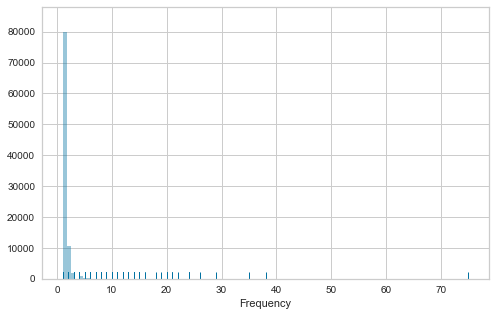

In [122]:
plt.figure(figsize=(8,5))
sns.distplot(rfm.Frequency,bins=100,kde=False,rug=True)

Text(0, 0.5, 'Frequency')

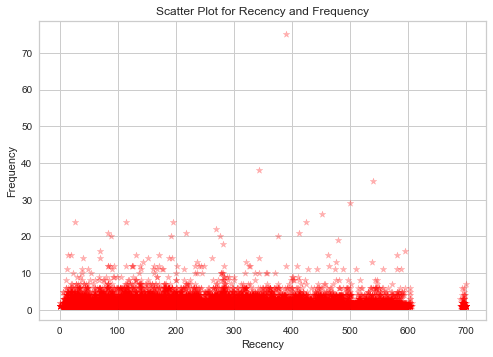

In [112]:
plt.scatter(rfm.groupby('customer_unique_id')['Recency'].sum(), rfm.groupby('customer_unique_id')['Frequency'].sum(),
            color = 'red',
            marker = '*', alpha = 0.3)

plt.title('Scatter Plot for Recency and Frequency') 
plt.xlabel('Recency')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

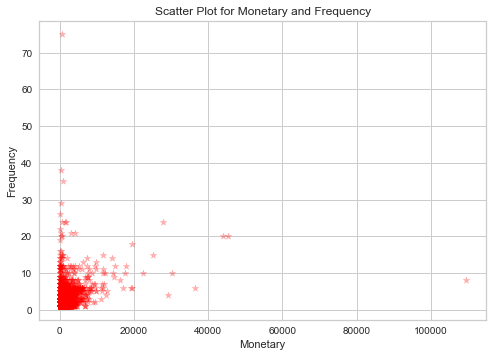

In [113]:
plt.scatter(rfm['Monetary'], rfm['Frequency'],
            color = 'red',
            marker = '*', alpha = 0.3)

plt.title('Scatter Plot for Monetary and Frequency')
plt.xlabel('Monetary')
plt.ylabel('Frequency')

On peut voir que les clients qui achètent le plus souvent dépense moins d'argent.